In [2]:
%matplotlib inline

<!-- omit in toc -->
# questions

* programme python qui prend une image array en entrée ?  
  terminal script.py + argument par ex l'image  
  $ python script.py --file pah_to_image.png  
  argparse librairie (pré installée)  
* sur colab comment importer sa bdd ?
* quelle méthode d'import de ds utiliser ? Celle avec keras ?
* keras.Input ?
* Faut il faire train/test/validation ? Si oui comment ?

<!-- omit in toc -->
# Classez des images à l'aide d'algorithmes de Deep Learning

<!-- omit in toc -->
# sommaire

- [1. Problématique](#1-problématique)

# 1. Problématique

Obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

C'est un exercice de classification supervisée dans le domaine de la computer vision.

**Processus**

1. mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutif) à comparer en termes de temps de traitement et de résultat
   1. Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
   2. Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.


transfer learning

obligatoire : réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.  
Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

Ressources de calcul

Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.  

Maitriser le preprocesing + CNN (structure, problematique optimisation diff hyperparametre)

comparer CNN  et transfer learning 

accuracy score pour évaluer ?
mesurer l'apport du preprocessing dans les resultats du modèle

mettre en oeuvre techniques de data augmentation
   algo gourmand en donnée pour
   à partir d'une image en créer plusieurs copies avec transformations pour que le modèle en connaisse plsueiurs formes 

Simulations pour opti le modèle (layers, etc)
Limiter le nb de classes pour réduire tps de traitement

sélectionner un modèle DL adapté
Champ d'application de classification
Au moins 2 modèles CNN 
au moins un modèle CNN transfer learning tel que VGG16, ResNet50, ou Inception ResNetV2

séparation train, test (mais sans sklearn ?)

kernel size, drop out, methode activation layer final
Expliquer au fur et à mesure ce qui est utilisé

adapter
optimizer, loss, sgd adam
batch size, nb d'epochs

résultats comparés de manière auto

transformation des variables
cropping, whitening, equalizer, débruitage, redimentionnement, miroring

montrer un exmple avant/après pour un des traitements

# 2. Cleaning/Exploration

### Librairies

In [1]:
# Generic librairies
import numpy as np
import pandas as pd
import os
import random
import xml.etree.ElementTree as ET

# images librairies
import cv2 # OpenCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras
# import seaborn as sns


# # Activate multi output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Variables

In [2]:
ini_img_dir = "../data/images/"
bnd_box_annotations_path = '../data/annotation/'

resized_dir = '../data/imgs_rzd/'
cropped_dir = '../data/imgs_crp/'

height=224
width=224

### Exploration

Notre jeu de donnée est le Stanford Dogs Dataset.  
Il est téléchargeable à cette adresse :  
http://vision.stanford.edu/aditya86/ImageNetDogs/

Il est constitué de photos de chiens qui sont classées par race.  
Il existe un sous dossier par race.

Etudions la quantité de données disponible :

In [4]:
breed_list = os.listdir(ini_img_dir)
nb_breed = len(breed_list)

In [6]:
n_tot_img = 0
img_per_breed = []
for breed in breed_list:
    nb_img = len(os.listdir(ini_img_dir + breed))
    n_tot_img += len(os.listdir(ini_img_dir + breed))
    img_per_breed.append(nb_img)
    
print("Nous avons {} races et {} images.\nCela fait {} images/race en moyenne".format(nb_breed, n_tot_img, n_tot_img/nb_breed))

Nous avons 120 races et 20580 images.
Cela fait 171.5 images/race en moyenne


### Distribution

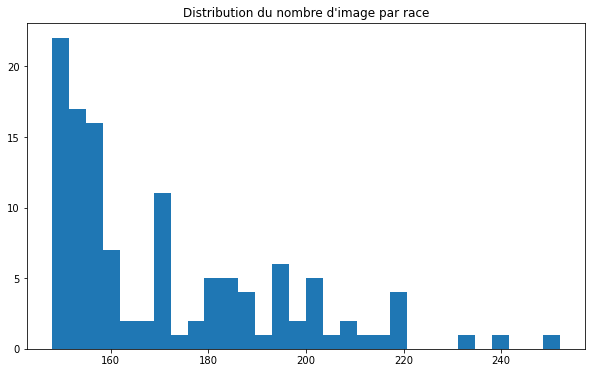

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(img_per_breed, bins=30)
plt.title('Distribution du nombre d\'image par race')
plt.savefig('../img/distri_img.png')
plt.show()

In [8]:
print("Nombre minimum d'images dans une classe : {}".format(min(img_per_breed)))

Nombre minimum d'images dans une classe :148


### Echantillon d'images

In [59]:
def show_images_sample(nb_breed_to_show):
    '''show 4 firsts images of nb_breed_to_show breed choosen randomly'''

    nb_breed_to_show = int(nb_breed_to_show)

    plt.figure(figsize=(16,nb_breed_to_show*4))

    # fig.suptitle(breed, fontsize=20)
    for i in range(nb_breed_to_show):
        breed = random.choice(breed_list)
        img_dir = ini_img_dir + breed
        images = os.listdir(img_dir)[:4] # select 4 first images names

        for image_nb in range(4):
            plt.subplot(nb_breed_to_show, 4, (image_nb+1)+4*(i))
            img = mpimg.imread(img_dir + '/' + images[image_nb])
            plt.imshow(img)
            if image_nb == 0: # title only one the 1st image
                plt.title(breed)
            plt.axis('off')

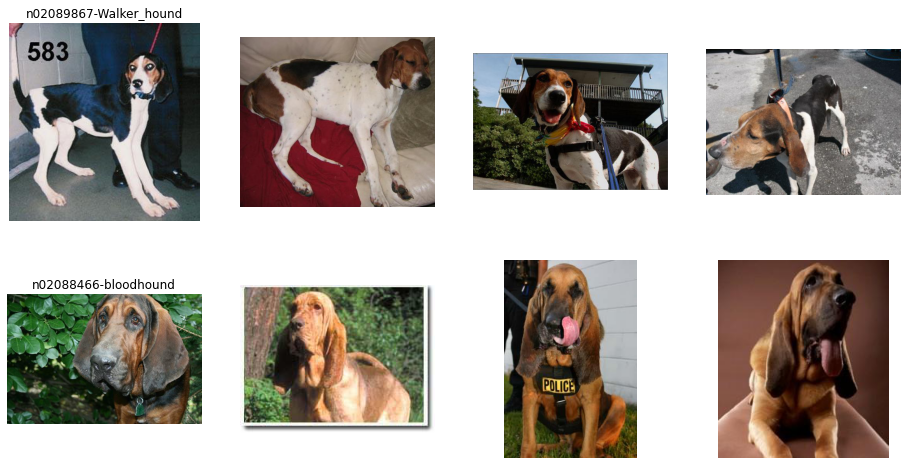

In [60]:
show_images_sample(2)

### Filtre images corrompues

Nous travaillons avec de nombreuses données d'images du monde réel, les images corrompues sont un phénomène courant.  
Filtrons les images mal encodées qui ne comportent pas la chaîne "JFIF" dans leur en-tête.

Déterminons tout d'abord si nous avons des images corrompues.  
Si c'est le cas nous les supprimerons après preprocessing si nécessaire.

In [12]:
def filter_corrupted(initial_path, remove=False):
    num_skipped = 0
    for folder_name in os.listdir(initial_path):
        folder_path = os.path.join(initial_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                if remove:
                    os.remove(fpath)

    print("%d images corrompues" % num_skipped)

In [13]:
filter_corrupted(ini_img_dir)

10 images corrompues


# 3. Preprocessing

## 3.1 Resize / crop

Nous allons commencer par définir des fonctions permettant de changer la taille de nos images et de les recadrer grâces aux bounding box fournies avec le dataset.

In [16]:
# depreciated since I will use a resize function and another function to apply it to the entire dataset
# def resize_dataset(ini_img_dir, resized_img_dir, height, width, bnd_box_annotation_dir=None):
#     '''resize images to 224x224px
#     if bnd_box_annotation_dir != None it will select the proper box and then crop the image
#     ini_img_dir and bnd_box_annotation_dir must have the same subdirectories and files names (except for file extension)
#     '''
#     if not os.path.isdir(resized_img_dir):
#         os.mkdir(resized_img_dir)

#     breed_list = os.listdir(ini_img_dir)

#     for breed in breed_list:
#         os.mkdir(resized_img_dir + breed)
#         # list of img names without extention as we could use this name for annotations whose are without it.
#         breed_file_list = [os.path.splitext(filename)[0] for filename in os.listdir(ini_img_dir + '{}'.format(breed))]

#         for file in breed_file_list:
#             img = Image.open(ini_img_dir + '{}/{}.jpg'.format(breed, file))
#             # select only the bound box
#             if bnd_box_annotation_dir!=None:
#                 tree = ET.parse(bnd_box_annotation_dir + '{}/{}'.format(breed, file))
#                 xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
#                 xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
#                 ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
#                 ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
#                 img = img.crop((xmin, ymin, xmax, ymax))
#             img = img.convert('RGB')
#             img = img.resize((height, width))
#             img.save(resized_img_dir + '{}/{}.jpg'.format(breed, file))

#     print('Created {} folders to store cropped images of the different breeds.'.format(len(breed_list)))


In [15]:
def resize_img(img_path, height=224, width=224, bnd_box_annotations_path=None):
    '''resize one image to height x width pixels return the image
    If bnd_box_annotations_path!=Nnne it will select the proper box and then crop the image before the resize
    ini_img_dir and bnd_box_annotation_dir must have the same subdirectories and files names (except for file extension)
    '''
    img = Image.open(img_path)
    if bnd_box_annotations_path!=None:
        path_no_extension = os.path.splitext(img_path)[0]
        file_name = os.path.split(path_no_extension)[1]
        # take the breed from the initial image path
        breed = os.path.split(os.path.split(path_no_extension)[0])[1]
        img_annotation_dir = bnd_box_annotations_path + '{}/{}'.format(breed, file_name)
        tree = ET.parse(img_annotation_dir)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((height, width))
    return img

# A éventuellement modifier pour pouvoir spécifier un nombre de race
def all_dataset(function_to_apply, initial_path, saving_path, height=224, width=224, bnd_box_annotations_path=None):
    '''apply a function to our entire dataset 
    save new data to saving_path keeping same directories
    '''
    os.mkdir(saving_path)

    breed_list = os.listdir(initial_path)

    for breed in breed_list:
        breed_path = saving_path + breed
        os.mkdir(breed_path)

        # list of img names with extentions
        breed_file_list = os.listdir(initial_path + breed)

        for file in breed_file_list:
            img_path = initial_path + '{}/{}'.format(breed, file)
            img = function_to_apply(img_path, height, width, bnd_box_annotations_path)
            img.save(saving_path + '{}/{}'.format(breed, file))


In [5]:
all_dataset(resize_img, ini_img_dir, resized_dir)
all_dataset(resize_img, ini_img_dir, cropped_dir, bnd_box_annotations_path=bnd_box_annotations_path)

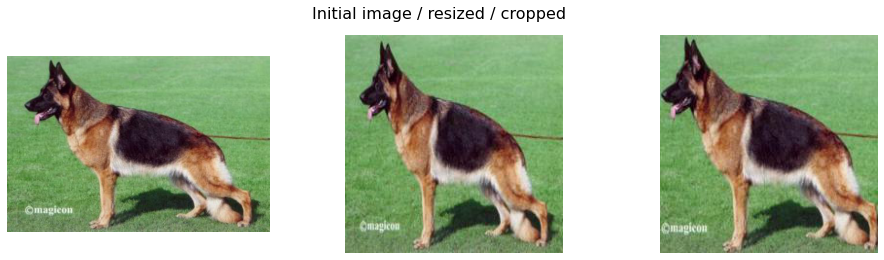

In [9]:
fig = plt.figure(figsize=(16, 4))

breed = random.choice(breed_list)

fig.suptitle('Initial image / resized / cropped', fontsize=16)
for i, dir in enumerate([ini_img_dir, resized_dir, cropped_dir]):
    img_dir = dir + breed
    images = os.listdir(img_dir)[0] # select 4 first images names
    plt.subplot(1, 3, i+1)
    img = mpimg.imread(img_dir + '/' + images)
    plt.imshow(img)
    plt.axis('off')


## 3.1 whitening


Dans les images naturelles, les pixels ont tendance à être corrélés avec leurs voisins.  
Le whitening supprime ces corrélations.

L'application du whitening PCA a pour effet de normaliser les images pour les écarts naturels.  
Cette normalisation améliore la précision des comparaisons que nous effectuons entre différentes parcelles d'image en utilisant la distance euclidienne.  
La distance entre les taches blanchies est une bien meilleure mesure de leur similitude que la distance entre les taches non blanchies. 

Nous utilisons d'abord l'ACP pour trouver les directions de variance et projeter les données dans ces directions.  
Ensuite, nous pouvons facilement normaliser la variance. 

L'étape de blanchiment effectue une extraction de caractéristiques qui, dans cet exemple, donne à la comparaison de distance une certaine invariance par rapport aux changements de luminosité.

<img src="..\img\pixel_4_5_correlation.png" width="400px"><img src="..\img\pixel_4_5_correlation_after_whiten.png" width="400px">    

Nous utiliserons le whitening à partir de la méthode Keras permettant de faire de la data augmentation.

## 3.2 data augmentation

>La data augmentation est une technique utilisée pour augmenter la quantité de données.  
>On y ajoute des copies légèrement modifiées de données déjà existantes ou de données synthétiques nouvellement créées à partir de données existantes.  
>Il agit comme un régulateur et aide à réduire le surapprentissage lors de la formation d'un modèle d'apprentissage automatique.

In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

testsplit = .2
zca_epsilon = 1e-6
zca_whitening = True

In [5]:
data_gen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

data_gen_wh = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input,
        zca_whitening=zca_whitening,
        zca_epsilon=zca_epsilon,
)

In [18]:
# image_classification_from_scratch
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## 3.3 histogram equalization



# 4. CNN spécifique

Nous allons tout d'abord créer un réseau de neuronne convolutif entier avant de l'entrainer et de le tester


## 4.1 Création du model

### Loading dataset and labels

In [ ]:
batch_size = 64


# learning_rate = 0.0001
# classes = 120
seed = 42

In [25]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  resized_dir,
  labels='inferred',
  batch_size=batch_size,
  image_size=(height, width),
  validation_split=testsplit,
  subset='training',
  seed=seed)

test_ds = keras.preprocessing.image_dataset_from_directory(
  resized_dir,
  labels='inferred',
  batch_size=batch_size,
  image_size=(height, width),
  validation_split=testsplit,
  subset='validation',
  seed=seed)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [10]:
train_ds_gen = data_gen.flow_from_directory(
        resized_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_ds_gen = data_gen.flow_from_directory(
        resized_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [8]:
train_ds_gen_wh = data_gen_wh.flow_from_directory(
        resized_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_ds_gen_wh = data_gen_wh.flow_from_directory(
        resized_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Train sample with endoded labels

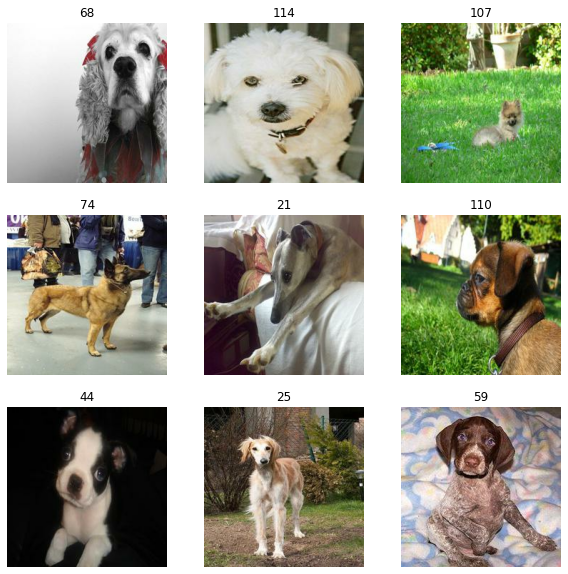

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Train sample with data augmentation

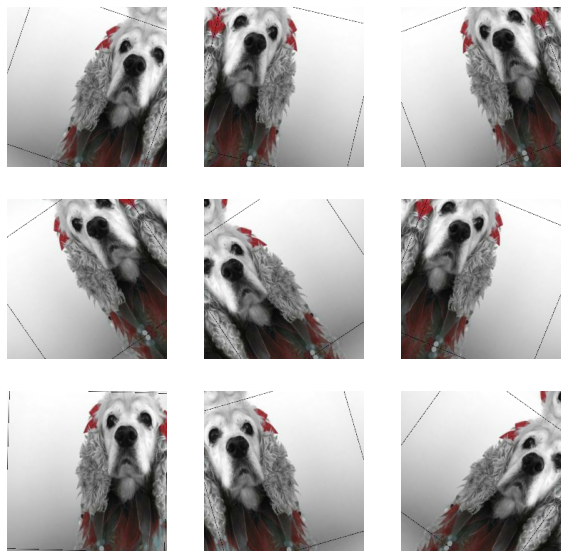

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Depreciated

In [6]:
breed_list = os.listdir(resized_img_dir)

label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

def paths_and_labels(img_dir):
    '''Create lists with respectivly paths, labels, and label number of files'''

    paths = list()
    labels = list()
    targets = list()

    for breed in breed_list:
        breed_dir = img_dir +'{}/'.format(breed)
        breed_img_list = os.listdir(breed_dir)

        for img_name in breed_img_list:
            paths.append(breed_dir + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels(resized_img_dir)

assert len(paths) == len(labels)
assert len(paths) == len(targets)

# clarifier label/target (un seul nom)
# liste pour les labels ok

In [15]:
# import

# enregistrer les images dans une variable en 4D

def load_imgs(paths):
	"""Load all images in paths list and return a list"""
	loaded_images = []
	for path in paths:
		# load image
		img_data = mpimg.imread(path)
		# store loaded image
		loaded_images.append(img_data)
	print('> loaded {} images.'.format(len(loaded_images)))
	return np.asarray(loaded_images)

data = load_imgs(paths)


> loaded 20580 images.


### Model creation

In [30]:
nb_of_channels = 3

# inputs = keras.Input(shape=(height, width, nb_of_channels))
# x = data_augmentation(inputs)

x = data_augmentation(train_ds[0])
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

TypeError: 'BatchDataset' object is not subscriptable

In [15]:
# augmented_train_ds = train_ds.map(
#   lambda x, y: (data_augmentation(x, training=True), y))

Configure the dataset for performance  
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [57]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [16]:
# from tensorflow.keras.layers.experimental.preprocessing import Normalization

# normalizer = Normalization(axis=-1)
# normalizer.adapt(dataset_train)

# normalized_data = normalizer(dataset_train)
# print("var: %.4f" % np.var(normalized_data))
# print("mean: %.4f" % np.mean(normalized_data))

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:

# define the keras model
model = Sequential()

model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=150, batch_size=10)


In [46]:
model = Sequential()

# Base d'un CNN
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(height, width, nb_of_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Spécifique au données
model.add(Flatten())
model.add(Dense(len(train_ds.class_names), activation='softmax'))
model.add(Dense(1, activation='softmax'))


# Résumé du modèle
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)            

In [47]:
from keras.callbacks import EarlyStopping, History

model.compile(optimizer='adam', # TO DO : essayer avec RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=5)

history = model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks = [early_stopping_monitor])

plot_result_fitting(history)

Epoch 1/100
 15/165 [=>............................] - ETA: 14:39 - loss: 0.0000e+00 - accuracy: 0.0080

KeyboardInterrupt: 

Convertir images en vecteur (flatten)  
ou  
réseaux de neurones convolutionnels qui préserves la structure de l'image

## 4.2 Entrainement

## 4.3 Evaluation

Nous utiliserons pour l'évaluation la "Loss-Function" et l'"Accuracy".  
Il s'agit de façon équivalente de diminuer la première et d'augmenter la seconde.


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

# 5. Transfert learning


## 5.1 VGG16 InceptionV3 Xception resnet50


# 6. Application


# 7. Conclusion et résultats